## Лабораторная работа "Линейные модели"

Некоторые задачи в этом ноутбуке надо будет сдавать в [контест](https://new.contest.yandex.ru/60377/start). Когда сдаете туда код, не забудьте сверху прописать все нужные импорты.

Мы рассчитываем, что перед тем, как садиться за этот ноутбук, вы прочитали часть про регрессию главы "Линейные модели" хендбука по ML.

Начнём с загрузки необходимых библиотек и функций.

Параметр `seed` будет использоваться далее для инициализации генератора случайных чисел из библиотеки `numpy`.

In [14]:
#!python3 -m pip install scikit-learn
!curl https://api.openml.org/data/get_csv/20649135/file2ed11cebe25.arff > data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1646k    0 1646k    0     0  1412k      0 --:--:--  0:00:01 --:--:-- 1411k


In [27]:
import numpy as np
import pandas as pd
from typing import Optional, List
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
seed = 24

В этом ноутбуке мы будем практиковаться на датасете ["The Ames Iowa Housing Data"](https://www.openml.org/d/41211). Здесь собраны описания и цены жилья в городе Эймс, штат Айова. Мы будем решать задачу предсказания цены (`Sale_Price`) по всем остальным признакам.

И начнём мы, конечно, с того, что внимательно посмотрим на датасет: какие там есть объекты и какие признаки.

In [9]:
## Uncomment the line below to download data and install necessary packages
## Maybe won't work on Windows :(

# !curl https://api.openml.org/data/get_csv/20649135/file2ed11cebe25.arff > data.csv

SyntaxError: invalid syntax (1893613787.py, line 3)

In [98]:
data = pd.read_csv('./data.csv')



In [18]:
#data.info()

Разобьём данные на обучающую и тестовую выборки.

In [158]:
target_column = "Sale_Price"
np.random.seed(seed)

test_size = 0.2
data_train, data_test, Y_train, Y_test = train_test_split(
    data[data.columns.drop("Sale_Price")],
    np.array(data["Sale_Price"]),
    test_size=test_size,
    random_state=seed)

print(f"Train : {data_train.shape} {Y_train.shape}")
print(f"Test : {data_test.shape} {Y_test.shape}")

Train : (2344, 80) (2344,)
Test : (586, 80) (586,)


Среди признаков нам встретятся как вещественные, так и категориальные. Пока что выделим в качестве категориальных те, значениями которых являются не числа, а какие-то другие сущности (но имейте в виду, что численные с виду признаки тоже могут быть категориальными).

In [100]:
continuous_columns = [key for key in data.keys() if data[key].dtype in ("int64", "float64")]
categorical_columns = [key for key in data.keys() if data[key].dtype == "object"]

continuous_columns.remove(target_column)

print(f"Continuous : {len(continuous_columns)}, Categorical : {len(categorical_columns)}")

Continuous : 34, Categorical : 46


Посмотрим на заголовки признаков. В целом, многие названия вполне говорящие, и можно догадаться, что стоит за этими признаками.

In [53]:
continuous_columns

['Lot_Frontage',
 'Lot_Area',
 'Year_Built',
 'Year_Remod_Add',
 'Mas_Vnr_Area',
 'BsmtFin_SF_1',
 'BsmtFin_SF_2',
 'Bsmt_Unf_SF',
 'Total_Bsmt_SF',
 'First_Flr_SF',
 'Second_Flr_SF',
 'Low_Qual_Fin_SF',
 'Gr_Liv_Area',
 'Bsmt_Full_Bath',
 'Bsmt_Half_Bath',
 'Full_Bath',
 'Half_Bath',
 'Bedroom_AbvGr',
 'Kitchen_AbvGr',
 'TotRms_AbvGrd',
 'Fireplaces',
 'Garage_Cars',
 'Garage_Area',
 'Wood_Deck_SF',
 'Open_Porch_SF',
 'Enclosed_Porch',
 'Three_season_porch',
 'Screen_Porch',
 'Pool_Area',
 'Misc_Val',
 'Mo_Sold',
 'Year_Sold',
 'Longitude',
 'Latitude']

Одна из целей этого ноутбука — познакомить вас с fit-predict (fit-transform) интерфейсом, типичным для многих реализаций моделей машинного обучения и для различных инструментов работы с данными.

Множество фреймворков машинного обучения (например, scikit-learn, CatBoost) содержат в себе модели и алгоритмы, которые описаны в виде классов, у которых есть два ключевых метода: fit и predict (transform). Давайте разберёмся, что делают эти методы.

***fit*** — метод для обучения алгоритма. Он получает на входе данные и таргеты для обучения, после чего обновляет состояние класса. После использования метода fit считается, что объект класса готов к использованию. Внутри этого метода может быть что угодно: обучение модели, подбор гиперпараметров, подсчет статистик и т. д.

***predict*** — метод для предсказания , обученного с помощью _fit_. В задаче регрессии это оценка параметра, в задаче классификации предсказанный класс.

***transform*** — стилистический синоним _predict_, но используется в классах, которые реализуют преобразования данных, например, масштабирование признаков или кодирование категориальных фичей.

***fit_transform*** — метод который учится на данных, а потом их же преобразовывает.

### 1. Базовая предобработка данных

Отметим два важных свойства линейной регрессии:

- строго говоря, она умеет работать только с вещественными признаками
- если признаки имеют разный масштаб при сопоставимой важности, регрессия может проигнорировать те, что имеют меньший масштаб

Первое соображение заставляет придумывать способы борьбы с категориальными признаками, и мы начнём с самого простого: проигнорируем их.

Второе соображение приводит к необходимости приводить признаки к одному масштабу ("нормализовать фичи"). В `sklearn` для этого есть два основных класса:

- [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) - в каждой колонке вычитает среднее и делит на стандартное отклонение.
- [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - в каждой колонке вычитает минимальное значение и делит на разницу между минимальным и максимальным.

Применяются они в соответствии с описанной выше философией. Например:

```
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
```

Обратите внимание, что scaler настраивается на обучающей выборке (именно по ней вычисляются среднее и стандартное отклонение), а к тестовой он применяется с уже подсчитанными статистиками.

**Вопрос**. А зачем? Почему бы не нормировать отдельно обучающую и тестовую выборку? Почему бы не настроить наш scaler на объединении двух выборок? Ведь благодаря большему количеству данных мы бы настроили его точнее!
<p>
<details>
  <summary>Кликните, чтобы узнать ответ</summary>

Если мы по-разному отнормируем обучающую и тестовую выборки, то нам будет весьма сложно применять модель, обученную на одной из них, к другой. Это просто не будет иметь физического смысла.

Настраивать что-либо на тестовой выборке — это очень плохая идея. Тестовая выборка должна быть неким независимым мерилом качества наших усилий по предсказанию, а если мы разрешим информации о распределении признаков в тестовой выборке "протечь" в процесс обучения, то мы эту независимость испортим.

</details>

Итак, мы решили делать преобразование данных, которое состоит в:

- сохранении лишь непрерывных фичей;
- нормализации этих фичей (давайте остановимся на [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html))

В этом пункте вам нужно будет сделать класс такой предобработки данных, причём оформим мы его в виде класса с интерфейсом fit-transform.

Несколько важных соображений:

1. В прошлой лабораторной метод fit у нас ничего не возвращал, но правильнее сделать так, чтобы метод fit возвращал сам класс. В частности, это позволит нам писать model = model.fit().

2. Первоначальный анализ данных удобно делать, когда они лежат в pd.DataFrame, т к у этого класса много методов, которые малым количеством телодвижений позволяют считать статистики и строить графики. Модели же проще учить, когда данные лежат в np.array, потому большое количество библиотек, где реализованы алгоритмы машинного обучения совместимы именно с numpy. Поэтому сделайте так, чтобы метод transform получал на вход pd.Dataframe, а возвращал np.array.

3. В sklearn есть классы, от которых можно отнаследоваться, чтобы сделать класс с [fit-predict](https://scikit-learn.org/stable/modules/generated/sklearn.base.RegressorMixin.html#sklearn.base.RegressorMixin) или [fit-transform](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) интерфейсом. Это очень полезно, т к позволит вам в дальнейшем пользоваться методами [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) и подобными. В этом пункте отнаследуйтесь от второго.

4. У метода __init__ должен быть параметр ```needed_columns=None```. Туда передается список колонок, которые нужно взять из датафрейме. Делать это надо в ```fit``` и ```transform```. В случае если если он равен None, то класс оставляет все колонки из исходного набора данных.

5. Обратите внимание, что достаточно реализовать `fit` и `transform`, а метод `fit_transform` из них слепит родительский класс.

**Готовый препроцессор вам нужно будет сдать в Контест**

In [160]:
class BaseDataPreprocessor(TransformerMixin):
    def __init__(self, needed_columns: Optional[List[str]]=None):
        """
        :param needed_columns: if not None select these columns from the dataframe
        """
        self.scaler = StandardScaler()
        self.needed_columns=needed_columns

    def fit(self, data: pd.DataFrame, *args):
        """
        Prepares the class for future transformations
        :param data: pd.DataFrame with all available columns
        :return: self
        """
        if self.needed_columns is None:
            columns=data.columns
        else:
            columns=self.needed_columns

        self.columns_ = columns
        self.scaler.fit(data[self.columns_])
        return self

    def transform(self, data: pd.DataFrame) -> np.array:
        """
        Transforms features so that they can be fed into the regressors
        :param data: pd.DataFrame with all available columns
        :return: np.array with preprocessed features
        """
        X = data[self.columns_]

        
        X_scaled = self.scaler.transform(X)
        
        return X_scaled

**1. Сдайте вашу реализацию в Контест, задача «Простая предобработка».**

In [161]:
preprocessor = BaseDataPreprocessor(needed_columns=continuous_columns)

X_train = preprocessor.fit_transform(data_train)
X_test = preprocessor.transform(data_test)
X_train

array([[ 0.72781797,  0.10999732,  0.65825008, ...,  0.91897402,
         1.59953221, -2.10399441],
       [ 0.28278084,  0.3792301 ,  1.09413674, ...,  1.67878887,
        -0.03026421,  1.46544646],
       [ 0.63881055, -0.1507842 , -0.4147017 , ..., -1.36047053,
         1.4104223 ,  0.21280896],
       ...,
       [ 0.52013398,  0.4287303 , -0.71646938, ..., -0.60065568,
         0.65006975, -0.71551757],
       [ 0.22344256,  0.09261189, -0.4147017 , ...,  0.91897402,
        -0.82561363, -0.89443458],
       [ 0.22344256, -0.36327285, -0.14646375, ...,  0.91897402,
         0.69254025,  0.78026581]], shape=(2344, 34))

### 1.2 Умная предобработка данных

Теперь давайте попробуем сделать что-нибудь поинтереснее. Для того, чтобы будущие алгоритмы регрессии работали хорошо, они должны обучаться и предсказывать на информативных фичах. Зачастую оказывается гораздо продуктивнее потратить какое-то время на изучение предметной области и придумывание хороших фичей (feature engineering), нежели жадно перебирать все известные алгоритмы машинного обучения.
В этом пункте попробуйте придумать новых фичей и написать новый класс предобработки данных, который их добавляет (а, возможно, и убирает ещё какие-то старые).

В конце этого пункта в раскрывашке перечислены наши идеи относительно того, что можно было добавить.

In [47]:
class SmartDataPreprocessor(TransformerMixin):
    def __init__(self, needed_columns: Optional[List[str]]=None):
        """
        :param needed_columns: if not None select these columns from the dataframe
        """
        self.scaler = StandardScaler()
        self.needed_columns = needed_columns
        self.columns_ = None
        self.original_columns_ = None  # Добавлено: исходные колонки без dist_to_center
        self.cityC_ = None
        self.medians_ = None
    
    def fit(self, data: pd.DataFrame, *args):
        """
        Prepares the class for future transformations
        :param data: pd.DataFrame with all available columns
        :return: self
        """
        df = data.copy()
        if self.needed_columns is None:
            df = df[[col for col in df.columns if df[col].dtype != 'object']]
            self.original_columns_ = list(df.columns)
        else:
            df = df[[col for col in df.columns if col in self.needed_columns]]
            self.original_columns_ = [col for col in self.needed_columns if col in df.columns]
            
        # центр
        lat = data["Latitude"].median()
        long = data["Longitude"].median()
        self.cityC_ = (lat, long)
        df["dist_to_center"] = np.sqrt(
            (data["Latitude"] - lat) ** 2 +
            (data["Longitude"] - long) ** 2)
        
        # Финальный список колонок (с dist_to_center)
        self.columns_ = self.original_columns_ + ["dist_to_center"]
        
        # Вычисляем медианы и обучаем scaler
        self.medians_ = df.replace(0, np.nan).median()
        df_clean = df.replace(0, np.nan).fillna(value=self.medians_)
        self.scaler.fit(df_clean[self.columns_])
        return self
    
    def transform(self, data: pd.DataFrame) -> np.array:
        """
        Transforms features so that they can be fed into the regressors
        :param data: pd.DataFrame with all available columns
        :return: np.array with preprocessed features
        """
        df = data.copy()
        
        # --- 1. выбрать исходные колонки (без dist_to_center) ---
        df = df[self.original_columns_]
        
        # --- 2. вычислить dist_to_center ---
        lat_c, lon_c = self.cityC_
        df["dist_to_center"] = np.sqrt(
            (data["Latitude"] - lat_c) ** 2 +
            (data["Longitude"] - lon_c) ** 2
        )
        
        # --- 3. заполнить нули и NaN ---
        df = df.replace(0, np.nan).fillna(value=self.medians_)
        
        # --- 4. нормализация ---
        X_scaled = self.scaler.transform(df[self.columns_])
        
        return X_scaled

In [48]:
#preprocessor = SmartDataPreprocessor(needed_columns=continuous_columns)

#X_train = preprocessor.fit_transform(data_train)
#X_test = preprocessor.transform(data_test)

<details>
  <summary>Пара простых идей. Кликните, когда будете готовы</summary>

Например в датасете есть координаты квартиры, которые по идее сами по себе мало чего дают нашему регрессору. С другой стороны, по ним можно оценить центр города (или просто найти его на карте) и использовать в качестве фичи расстояние до центра города, которое может естественным образом влиять на цену жилья.

Ещё может быть полезным почистить пропуски. И тут есть хитрость. Если вы просто вызовете data.info(), то вам покажется, что пропусков нет, но они могут приходить под разными обличьями. Например, у 490 объектов параметр Lot_Frontage (площадь фасада) равен нулю. Неожиданно, правда? Возможно, мы хотим эти нулевые значения заменить чем-нибудь, скажем, медианой.

</details>


### 2. Линейная регрессия

Давайте получим базовое решение (бейзлайн), чтобы потом с ним можно было сравниваться.

Обучите линейную регрессию на обучающей выборке (которую мы подвергли преобразованию BaseDataPreprocessor). В библиотеке Sklearn есть релизация [без регуляризации](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linear%20regression), [с L2-регуляризацией](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) и [с L1-регуляризацией](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso).

Начнём с обычной регрессии. Получите предсказания на тестовых данных и оцените на них качество модели. В качестве метрики оценки качества возьмите [средний модуль отклонения](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) (mean absolute error, MAE). Как вам кажется, насколько хорошей вышла модель?


In [69]:
from sklearn.metrics import mean_absolute_error 
from sklearn.linear_model import LinearRegression, Ridge
model = LinearRegression()
model.fit(X_train,Y_train)
pred=model.predict(X_test)
mae=mean_absolute_error(Y_test,pred)
mae

23822.6965186552

Теперь попробуйте L2-регуляризованную модель Ridge(). Какие значения метрик она даёт?

In [84]:
ridge_model = Ridge(0.0001)
ridge_model.fit(X_train,Y_train)
pred=ridge_model.predict(X_test)
mae=mean_absolute_error(Y_test,pred)
mae

23822.69644670203

В целом, регуляризация редко портит модель, но важно правильно подобрать коэффициент регуляризации. Как именно — поговорим дальше.

### 3. Выбор метрики

Средний модуль ошибки (MAE) — в целом довольно хорошая метрика для задачи регрессии, потому что ее довольно легко проинтерпретировать. Но с ней есть одна проблема: ошибиться на $ 10 000 $ USD в предсказании цены квартиры стоимостью $ 100 000 $ USD страшнее чем допустить такую ошибку в предсказании цены жилья за $ 700 000 $ USD. Иными словами более показательной метрикой будет не абсолютная  ошибка $ error_i = |y_i - \hat{y_i}|$, а логарифм относительной ошибки $error_i = log \frac{y_i}{\hat{y_i}} $. Также давайте обычное усреднение по всем примерам в тестовой выборке заменим на среднеквадратичное $ \frac{1}{N} \sum_i^{test} {error_i} \longrightarrow \sqrt{\frac{1}{N} \sum_i^{test}{(error_i)^2}}$. Итоговая метрика получается равной:

$$
Metric = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (log(y_i) - log(\hat{y_i}))^2}
$$

Логично? Да. Но возникает еще одна проблема. Логарифм нельзя брать от отрицательного числа. Бороться с этим можно двумя способами.
- Случай когда отрицательное число затисалось в target-ax не очень разумен, т. к. цена на дом не может быть отрицательной. В этом случае стоит кинуть ошибку, чтобы пользователь этой функции еще раз перепроверил правильные ли таргеты он подает.
- В целом, у нас нет гарантий того, что наша модель (например линейная) предсказывает только положительные числа. Брать логарифм от отрицательного числа не получится, но качество такой модели все еще надо оценить. Давайте все предсказания, которые меньше некоторого порога $ a_{min} $, заменять этим порогом ($ \hat{y_i} \longleftarrow max(\hat{y_i}, a_{min}) $), после чего подавать их в метрику. Для прохождения тестов возьмите $ a_{min} = 1 $.

**2. Реализуйте эту метрику и сдайте в контест**.

In [113]:
import numpy as np

def root_mean_squared_logarithmic_error(y_true, y_pred, a_min=1.):
    """
    Вычисляет Root Mean Squared Logarithmic Error (RMSLE).
    
    Формула: sqrt(mean((log(y_pred + 1) - log(y_true + 1))^2))
    
    :param y_true: истинные значения цен (должны быть положительными)
    :param y_pred: предсказанные значения
    :param a_min: минимальное значение для клиппинга предсказаний (по умолчанию 1.0)
    :return: значение RMSLE метрики
    """
   
    
    
    # Проверка: цены не могут быть отрицательными
    if np.any(y_true < 0):
        raise ValueError("y_true содержит отрицательные значения. Цена не может быть отрицательной!")
    
    # Клиппинг предсказаний: заменяем значения меньше a_min на a_min
    y_pred_clipped = np.clip(y_pred, a_min, None)
    
            
    # Вычисляем логарифмическую ошибку
    # Формула: log(y_true) - log(y_pred)
    log_error = np.log(y_true) - np.log(y_pred_clipped)
    
    # Вычисляем среднеквадратичную ошибку
    squared_log_error = log_error ** 2
    mean_squared_log_error = np.mean(squared_log_error)
    
    # Берем квадратный корень
    metric = np.sqrt(mean_squared_log_error)
    
    return metric

### 4. Логарифмирование таргета.

Вообще идея с логарифмированием таргета довольно хороша для этой задачи. Давайте посмотрим на распределение обычных и логарифмированных таргетов.

In [91]:
import matplotlib.pyplot as plt
def plot_target_distribution(Y_train, Y_test, ax, n_bins=20):
    ax.hist(Y_train, bins=n_bins, label="train", color="red", alpha=0.3, density=True)
    ax.hist(Y_test, bins=n_bins, label="test", color="blue", alpha=0.3, density=True)

    ax.legend()
    ax.set_xlabel("Value")
    ax.set_ylabel("Probability")


def plot_both_distributions(Y_train, Y_test):
    fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15, 6))

    plot_target_distribution(Y_train, Y_test, ax=ax0)
    ax0.set_title("Standard")

    plot_target_distribution(np.log(Y_train), np.log(Y_test), ax=ax1)
    ax1.set_title("Logarithmic")

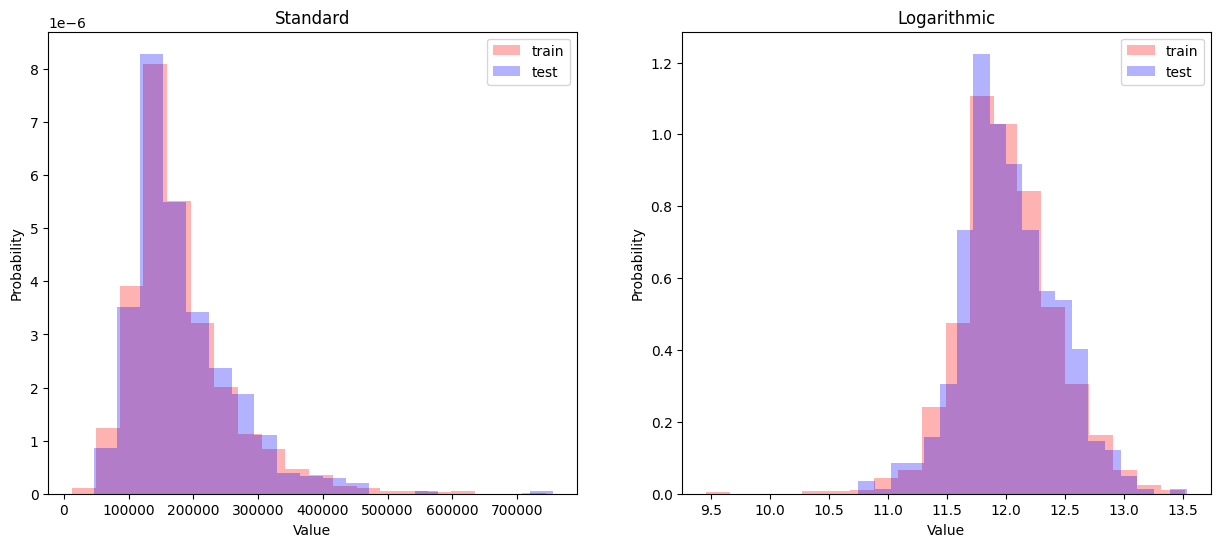

In [92]:
plot_both_distributions(Y_train, Y_test)

Как видите, если прологарифмировать таргеты, то их распределение станет более похоже на гауссовское. Интуиция подсказывает, что линейная регрессия с MSE loss-функцией должна лучше учиться на таких таргетах.

Попробуйте написать класс, который во время обучения логарифмирует таргет, а во время предсказания — наоборот, экспоненциирует. После чего обучите оба метода на обучающих данных и сравните значения метрик MAE и MSLE на тесте.

Что должно быть в этом классе:
- Класс должен называться ```ExponentialLinearRegression```
- Класс должен иметь такой же fit-predict интерфейс, как и было до этого. На вход он получает оригинальные X и Y, а уже внутри происходит логарифмирование или экспоненциирование.
- Внутри этой модели будет работать [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). Хочется, чтобы этому классу можно было передавать аргументы инициализации с помощью *args и **kwargs
- Чтобы потом этот класс можно было использовать в [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) в следующих пунктах, у него должны быть реализованы 5 методов
    1. ```__init__(self, *args, **kwargs)``` - все полученные аргументы передаются дальше в Ridge.
    2. ```fit(self, X, Y)``` - обучает класс, возвращает self.
    3. ```predict(self, X)``` - делает предсказание.
    4. ```get_params(deep=True)``` - возвращает dict с параметрами модели. Больще подробностей [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html)
    5. ```set_params(**params)``` - передает нужные параметры в модель. Больше подробносте [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html)
- Есть два подхода к тому как сделать все нужные методы:
    - Отнаследоваться от класса Ridge и переопределить методы fit и predict, внутри вызывая super() от отцовского класса.
    - Отнаследоваться от класса RegressorMixin и внутренним атрибутом класса сделать Ridge. Тогда все методы нужно будет писать руками.

In [135]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.base import RegressorMixin
class ExponentialLinearRegression(RegressorMixin):
    def __init__(self,*args, **kwargs):
        self.args=args
        self.kwargs=kwargs
        self.model=Ridge(*args,**kwargs)

    def fit(self, X, y):
        y_log=np.log(y)

        self.model.fit(X,y_log)
        return self

    def predict(self, X):

        pred1=self.model.predict(X)
        pred=np.exp(pred1)
        return pred

    def get_params(self, deep=True):
        return self.model.get_params(deep=deep)

    def set_params(self,  **params):
        self.model.set_params(**params)
        return self

**3. Реализуйте этот класс и сдайте в контест**.

In [136]:
classic_regressor = Ridge()
exponential_regressor = ExponentialLinearRegression()

classic_regressor.fit(X_train, Y_train)
exponential_regressor.fit(X_train, Y_train)

classic_prediction = classic_regressor.predict(X_test)
exponential_prediction = exponential_regressor.predict(X_test)

print(f"MAE  : Classic : {mean_absolute_error(Y_test, classic_prediction)}  Exponential : {mean_absolute_error(Y_test, exponential_prediction)}")
print(f"MSLE : Classic : {root_mean_squared_logarithmic_error(Y_test, classic_prediction)} Exponential : {root_mean_squared_logarithmic_error(Y_test, exponential_prediction)}")

MAE  : Classic : 23821.977761006794  Exponential : 26818.699786544297
MSLE : Classic : 0.1950062123328129 Exponential : 0.21601027716185375


Иногда получается так, что разные обученные вами модели приводят к улучшению одних метрик и ухудшению других. Это абсолютно нормально и этому не надо удивляться.

Также зачастую случается так, что прирост по метрике не очень большой. И вы можете захотеть убедиться, что это реальное улучшение, а не просто случайная флуктуация. Для этого можно использовать подсчёт метрики про кросс-валидации (подробнее о ней можно почитать в соответствующей главе учебника). Суть метода в следующем:

- мы разбиваем (случайным образом!) доступную нам выборку на $K$ (часто $K=5$) частей, которые называются _фолдами_
- мы обучаем нашу модель $K$ раз, уча на всех фолдах, кроме одного, а на этом одном тестируя
- мы получаем $K$ значений метрики, которые вместе дают нам лучшее представление о том, как ведёт себя модель на разных разбиениях на трейн и тест. В качестве итоговой метрики можно, к примеру, взять среднее полученных значений

Сделать всё это можно с помощью обёртки [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), в которую можно подать модель, датасет и интересующую вас метрику. При этом оценку по кросс-валидации можно делать на всей доступной у вас выборке (ибо кросс-валидация уже включает разбиение на трейн и тест).

Вычислите оценки MAE по кросс-валидации обычной (не регуляризованной) линейной регрессии и ExponentialLinearRegression на объединении обучающей и тестовой выборок.

**4. Посчитайте и сдайте две оценки по кросс-валидации в Контест**.

По шагам вам нужно
1. Применить BaseDataPreprocessor к исходным данным
2. Объединить трейн и тест
3. Для первого числа использовать LinearRegression()
4. Для второго -ExponentialLinearRegression с Ridge()
5. Разбиение на фолды сделать с помощью `cv=KFold(n_splits=5, shuffle=True, random_state=42)`

Обратите внимание, что параметр scoring — это не совсем функция-метрика, а немного более сложный объект, который можно соорудить, например, с помощью обёртки [make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer).

Также имейте в виду, что, вообще говоря, с дефолтным значением параметра `cv` кросс-валидация разбивает датасет на фолды детерминированным образом. Если вам нужно случайное разбиение, то в качестве cv стоит подать объект класса `sklearn.model_selection.KFold` или `sklearn.model_selection.StratifiedKFold`. Используйте

```
cv=KFold(n_splits=5, shuffle=True, random_state=42)
```

Также при написании кода для кросс-валидации вам может пригодиться знание о пайплайнах.

Представьте ситуацию. Прошел месяц с того момента, как вы построили модель, а теперь вам надо дообучить её на новых данных и активно применять для предсказания. Если вы не позаботились об инфраструктуре, то вам придётся рыскать по всему ноутбуку в поисках того, как вы предобрабатывали данные, какую модель учили, обязательно что-нибудь забудете и будете очень страдать. Поэтому человечество придумало пайплайны, которые позволяют объединить предобработку данных и обучение модели в один класс - pipeline. Его можно писать самому, либо взять из sklearn ([link](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html))

In [140]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error





# Шаг 2: Объединить трейн и тест
X_full = np.vstack([X_train, X_test])
y_full = np.concatenate([Y_train, Y_test])

print(f"Размер объединенной выборки: {X_full.shape}")
print(f"Размер таргета: {y_full.shape}")

# Шаг 3: Настройка кросс-валидации
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Создаем scorer для MAE (по умолчанию sklearn минимизирует, поэтому greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=True)

# Шаг 4: Модель 1 - Обычная LinearRegression
model_lr = LinearRegression()

scores_lr = cross_val_score(
    model_lr, 
    X_full, 
    y_full, 
    cv=cv, 
    scoring=mae_scorer
)

# Преобразуем отрицательные значения в положительные (sklearn возвращает негативные)
mae_lr = scores_lr.mean()
mae_lr_std = scores_lr.std()

print("\n=== LinearRegression ===")
print(f"MAE по фолдам: {scores_lr}")
print(f"Средний MAE: {mae_lr:.2f}")
print(f"Std MAE: {mae_lr_std:.2f}")

# Шаг 5: Модель 2 - ExponentialLinearRegression с Ridge
model_exp = ExponentialLinearRegression()

scores_exp = cross_val_score(
    model_exp, 
    X_full, 
    y_full, 
    cv=cv, 
    scoring=mae_scorer
)

mae_exp = scores_exp.mean()
mae_exp_std = scores_exp.std()

print("\n=== ExponentialLinearRegression ===")
print(f"MAE по фолдам: {scores_exp}")
print(f"Средний MAE: {mae_exp:.2f}")
print(f"Std MAE: {mae_exp_std:.2f}")

# Итоговые результаты для сдачи
print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ ДЛЯ КОНТЕСТА:")
print("="*50)
print(f"1. LinearRegression MAE: {mae_lr:.6f}")
print(f"2. ExponentialLinearRegression MAE: {mae_exp:.6f}")
print("="*50)

Размер объединенной выборки: (2930, 34)
Размер таргета: (2930,)

=== LinearRegression ===
MAE по фолдам: [22595.68621902 23360.20428404 24432.88513845 23440.35792502
 22296.80312688]
Средний MAE: 23225.19
Std MAE: 745.82

=== ExponentialLinearRegression ===
MAE по фолдам: [19788.7932268  22162.74052356 23405.46925681 20975.27526848
 19501.12941311]
Средний MAE: 21166.68
Std MAE: 1463.80

РЕЗУЛЬТАТЫ ДЛЯ КОНТЕСТА:
1. LinearRegression MAE: 23225.187339
2. ExponentialLinearRegression MAE: 21166.681538


### 5. Подбор гиперпараметров

Линейную регрессию почти всегда можно улучшить с помощью регуляризации. Но при этом у нас возникает **гиперпараметр** — коэффициент регуляризации, и подбирать его нужно правильно. Более подробно о подборе гиперпараметров вы можете прочитать в соответствующей главе учебника), а пока мы разберём самые базовые подходы.

В этой лабораторной вы познакомитесь с самым тривиальным способом — подбором по сетке. В данном случае это значит, что мы фиксируем несколько значений коэффициента регуляризации ```alpha``` и просто для каждого из них смотрим, что получится. Но важно отметить, что коэффициенты регуляризации стоит перебирать по _логарифмической_ сетке, например: `1e-2, 1e-1, 1, 1e+1, 1e+2`.

Разобравшись, что перебирать, перейдём к вопросу о том, как оценивать. Есть два основных подхода:

*   Train-Val-Test split. Датасет делится на три части, на одной модели учатся, на другой подбираются гиперпараметры, на третьей считаются финальные метрики. Этот метод довольно шумный, зато быстрый.
*   Кроссвалидация. Она значительно дольше, но надёжней. В этом пункте мы воспользуемся именно ей.


Возьмите класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) из scikit-learn и с его помощью подберите гиперпараметр ```alpha``` для линейной регрессии с L2-регуляризацией (соответствующий класс зовут Ridge). Возможно, для минимизации разных метрик (_root_mean_squared_logarithmic_error_ и _mean_absolute_error_) понадобятся разные значения гиперпараметров. Выберите из сетки ```np.logspace(-3, 3, num=7, base=10.)``` значение, которое максимизирует _root_mean_squared_logarithmic_error_ для _ExponentialLinearRegression_ и

**5. Загрузите оптимальное значение коэффициента регуляризации в Контест**.

Параметр `cv` оставьте дефолтным или возьмите `cv=5` (результат не поменяется). Будьте внимательны: по умолчанию `best_score_` у `GridSearchCV` - это _самое большое значение_. Чтобы не попасться в эту ловушку, обратите внимание на параметр `greater_is_better` функции `make_scorer`.

In [145]:
from sklearn.model_selection import GridSearchCV 
param={"alpha":np.logspace(-3, 3, num=7, base=10.)}
print(param["alpha"])

log_score=make_scorer(root_mean_squared_logarithmic_error,greater_is_better=False)

scores=GridSearchCV(estimator=model_exp,param_grid=param,scoring=log_score,cv=5) 
scores.fit(X_full, y_full)

print(scores.best_params_)
alpha_1 = 100  # Или то, что у вас получилось

# Вариант 2: Ответ из контеста
alpha_2 = 10

# Проверьте оба на тестовой выборке
for alpha in [alpha_1, alpha_2]:
    model = ExponentialLinearRegression(alpha=alpha)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    rmsle = root_mean_squared_logarithmic_error(Y_test, y_pred)
    print(f"alpha={alpha}: RMSLE={rmsle:.6f}")

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
{'alpha': np.float64(100.0)}
alpha=100: RMSLE=0.212381
alpha=10: RMSLE=0.215594


### 6. Линейная модель своими руками

В этом разделе вы напишете собственный класс линейной модели, чтобы лучше разобраться, как работает обучение с помощью SGD.

Линейная модель делает предсказание по такой формуле:
$$
\hat{y_i} = \langle \vec{w}, \vec{x_i} \rangle + b
$$
Здесь $\vec{w}$ и b - обучаемые параметры. $\vec{x_i}$ - вектор фичей данного примера.
$\vec{w}$ и b находятся из задачи минимизации лосс функции:

$$
\vec{w}, b = {argmin}_{\vec{w}, b}(L) \ ; \ L = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y_i})^2 + \lambda \vec{w}^T\vec{w}
$$

Задачу минимизации лосс функции мы будем решать градиентным спуском. Для этого надо найти градиенты лосса по параметром модели.

$$
\nabla_b L = \frac{2}{N} sum(X \vec{w} + b - \vec{y})\\
\nabla_{\vec{w}} L = \frac{2}{N} X^T(X \vec{w} + b - \vec{y}) + 2\lambda \vec{w}
$$

Теперь давайте реализуем этот алгоритм ввиде класса с методами fit-predict.
Что в нем должно быть:
1. Класс должен называться ```SGDLinearRegressor```
2. Класс должен быть отнаследован от sklearn-овского класса [RegressorMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.RegressorMixin.html)
3. Класс должен инициализироваться со следующими гиперпараметрами:

    a. ```lr``` — learning rate. Длина шага градиентного спуска

    b. ```regularization``` — коэффициент λ из формулы выше
    
    c. ```delta_converged``` — устанавливает условие окончание обучение. В тот момент когда норма разности весов на соседних шагах градиентного спуска меньше чем ```delta_converged``` алгоритм перкращает обновлять веса
    
    d. ```max_steps``` — максимальное число шагов градиентного спуска
    
    e. ```batch_size``` — размер батча

4. Реализуйте **стохастический** градиентный спуск. На каждом шагу градиентного спуска должен формироваться батч размера ```batch_size``` из матрицы признаков. Это нужно для того чтобы алгоритм быстрее сходился. Батч может выбираться случайно на каждом шаге градиентного спуска, либо каждую эпоху можно перемешивать трейн выборку и итерироваться батчами по ней.

Обратите внимание при реализации SGD на следующие моменты (частые ошибки):
* не перепутайте, какие коэффициенты в SGD стоят при самой функции потерь, а какие — при регуляризационном члене. Правильный вариант: $\frac{\alpha}{batch\_size}$ при градиенте MSE, $\alpha\lambda$ при градиенте регуляризатора.
* для остановки нужно сравнивать норму, а не ее квадрат
* для правильного решения нужно не итерироваться по батчу,  а перемножать матрицы (иначе не зайдет по TL)
* метод `predict` должен возвращать одномерный numpy array (не двумерный вектор-столбец формы (X.shape[1], 1))

In [150]:
class SGDLinearRegressor(RegressorMixin):
    def __init__(self,
                 lr=0.01, regularization=1., delta_converged=1e-3, max_steps=1000,
                 batch_size=64):
        self.lr = lr
        self.regularization = regularization
        self.max_steps = max_steps
        self.delta_converged = delta_converged
        self.batch_size = batch_size

        self.W = None
        self.b = None

    def fit(self, X, Y):
        X = np.asarray(X)
        Y = np.asarray(Y).reshape(-1, 1)
        n_samples,n_features=X.shape
        self.b=0
        self.W=np.zeros((n_features,1))

        for i in range(self.max_steps):
            W_old = self.W.copy()
            b_old = self.b

            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            for start_idx in range(0, n_samples, self.batch_size):
                end_idx = min(start_idx + self.batch_size, n_samples)
                batch_indices = indices[start_idx:end_idx]
                X_batch = X[batch_indices]  
                Y_batch = Y[batch_indices]
                batch_size_actual = len(batch_indices)
                Y_pred = X_batch @ self.W + self.b 
                error = Y_pred - Y_batch
                grad_W = (2.0 / batch_size_actual) * (X_batch.T @ error) + 2 * self.regularization * self.W
                grad_b = (2.0 / batch_size_actual) * np.sum(error)
                self.W = self.W - self.lr * grad_W
                self.b = self.b - self.lr * grad_b
            W_diff = self.W - W_old
            b_diff = self.b - b_old
            
            # Норма разности весов
            norm_diff = np.sqrt(np.sum(W_diff ** 2) + b_diff ** 2)
            
            if norm_diff < self.delta_converged:
                break
        
        return self

    def predict(self, X):
        X = np.asarray(X)
        
        # Y_pred = X @ W + b
        Y_pred = X @ self.W + self.b
        return Y_pred.ravel()  

In [151]:
# Check yourself

model = SGDLinearRegressor()
model.fit(X_train, Y_train)

prediction = model.predict(X_test)
print(Y_test.shape, prediction.shape)
print("MAE : ", mean_absolute_error(Y_test, prediction))
print("Mean log : ", root_mean_squared_logarithmic_error(Y_test, prediction))

(586,) (586,)
MAE :  25376.60230485443
Mean log :  0.18896016766047316


### 7. Категориальные признаки

В самом начале ноутбука мы отбросили категориальные фичи, хотя они могут помочь нам сделать модель лучше. Давайте же научимся ими пользоваться.

Самый простой подход — это закодировать значения категориального признака числами, скажем, от $0$ до $C-1$, где $C$ — количество значений категориального признака. Иногда это может сработать, но для этого нужно, чтобы между значениями признака были определены отношения больше/меньше (такие признаки называются _ординальными_), причём соотношения между значениями должны быть более-менее линейными. В целом, не очень частая ситуация, поэтому так мы делать не будем.

Вместо этого мы будем использовать OneHotEncoding. Пусть некоторая категориальная фича имеет $C$ уникальных значений. Давайте эту фичу закодируем в виде $C$ столбцов, каждый из которых соответствует некоторому уникальному значению категориальной фичи. Для каждого элемента выборки будем класть единичку в столбец, соответствующий этой фиче, и нолики в остальные.

У этого метода есть недостаток. Если категориальная фича принимает слишком много значений, то вы нагенерируете много новых столбцов, каждый из которых будет содержать мало информации. Из-за них моделька может переобучиться.

Этот метод имплементирован [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). У него есть пара важных гиперпараметров, которые стоит упомянуть:
- ```handle_unknown``` - управляет обработкой незнакомых категорий на этапе `transform`. Число уникальных значений (и число столбцов) настраивается на обучающей выборке, и при дальнейшем применении может появиться значение, которого ещё не было. Если указать ```handle_unknown="ignore"```, все поля для такого объекта будут заполнены нулями.
- ```drop``` - если делать one-hot-encoding так как это описано выше, то сумма всех столбцов, соответствующих значениям категориальной фичи, будет равна единичному вектору. А такой вектор уже есть (он соответствует свободному члену). То есть признаки становятся линейно зависимыми, и это сломает процесс обучения линейной модели. Поэтому есть смысл для каждой фичи отбрасывать одну из получившихся колонок (```drop="first"```) или хотя бы делать это только для бинарных фичей (```drop="if_binary"```)

В этом пункте вам надо еще раз предобработать данные, добавив в них часть категориальных фичей, закодированных OneHotEncoding-ом. После этого обучите классификатор заново и выбейте лучшую метрику на тестовой выборке. А именно, мы добавим фичи "Overall_Qual", "Garage_Qual", "Sale_Condition", "MS_Zoning". Используйте значение параметра handle_unknown="ignore".

*На практике в некоторых версиях scikit-learn есть проблема с совместимостью `handle_unknown="ignore"` и `drop="first"` одновременно, поэтому вторым можно пожертвовать.

Класс будет наследоваться от BaseDataPreprocessor, так что в него можно будет передавать нужные для BaseDataPreprocessor параметры. Также это позволит не переписывать заново то, что происходит в базовом классе, а просто взывать к ним с помощью конструкции `super`.

In [169]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

interesting_columns = ["Overall_Qual", "Garage_Qual", "Sale_Condition", "MS_Zoning"]


class OneHotPreprocessor(BaseDataPreprocessor):
    """
    Препроцессор, который добавляет OneHot-кодирование категориальных признаков
    к базовой предобработке.
    """
    
    def __init__(self, **kwargs):
        """
        Инициализация. Передаёт все параметры в BaseDataPreprocessor.
        
        :param kwargs: параметры для BaseDataPreprocessor (например, needed_columns)
        """
        super(OneHotPreprocessor, self).__init__(**kwargs)
        
        # OneHotEncoder для категориальных признаков
        self.encoder = OneHotEncoder(
            handle_unknown="ignore",  # Игнорировать неизвестные категории
            sparse_output=False       # Возвращать numpy массив, а не sparse матрицу
        )
        
        # Сохраним названия колонок после OneHot
        self.onehot_feature_names_ = None
    
    def fit(self, data, *args):
        """
        Обучает препроцессор.
        
        :param data: pd.DataFrame с исходными данными
        :param args: дополнительные аргументы
        :return: self
        """
        # Сначала обучаем базовый препроцессор
        super(OneHotPreprocessor, self).fit(data, *args)
        
        # Обучаем OneHotEncoder на категориальных признаках
        categorical_data = data[interesting_columns]
        self.encoder.fit(categorical_data)
        
        # Сохраняем названия признаков после OneHot
        self.onehot_feature_names_ = self.encoder.get_feature_names_out(interesting_columns)
        
        return self
    
    def transform(self, data):
        """
        Преобразует данные.
        
        :param data: pd.DataFrame с исходными данными
        :return: np.array с предобработанными признаками
        """
        # Получаем базовые признаки от родительского класса
        base_features = super(OneHotPreprocessor, self).transform(data)
        
        # Применяем OneHotEncoder к категориальным признакам
        categorical_data = data[interesting_columns]
        onehot_features = self.encoder.transform(categorical_data)
        
        # Объединяем базовые признаки и OneHot признаки
        combined_features = np.hstack([base_features, onehot_features])
        
        return combined_features

preprocessor1 = OneHotPreprocessor(needed_columns=continuous_columns)

X_train = preprocessor1.fit_transform(data_train)
X_test = preprocessor1.transform(data_test)

model1 = SGDLinearRegressor()
model.fit(X_train, Y_train)

prediction = model.predict(X_test)
print(Y_test.shape, prediction.shape)
print("MAE : ", mean_absolute_error(Y_test, prediction))
print("Mean log : ", root_mean_squared_logarithmic_error(Y_test, prediction))

(586,) (586,)
MAE :  24815.259366894774
Mean log :  0.18660785687224912


Обучите модель с добавленными категориальными фичами. Получилось ли улучшить её качество?

### 8. Pipeline

Представьте ситуацию. Прошел месяц с того момента, как вы построили модель, а теперь вам надо дообучить её на новых данных и активно применять для предсказания. Если вы не позаботились об инфраструктуре, то вам придётся рыскать по всему ноутбуку в поисках того, как вы предобрабатывали данные, какую модель учили, обязательно что-нибудь забудете и будете очень страдать. Поэтому человечество придумало пайплайны, которые позволяют объединить предобработку данных и обучение модели в один класс — pipeline. Его можно писать самому, либо взять из sklearn ([link](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)).

**7. Напишите пайплайн, объединяющий использованную нами базовую предобработку данных (BaseDataPreprocessor и OneHotPreprocessor), а также линейную регрессию с L2-регуляризацией, и сдайте его в Контест.**

In [172]:
from sklearn.pipeline import Pipeline
def make_ultimate_pipeline():
    pipeline = Pipeline([
        ('preprocessor', OneHotPreprocessor()),
        ('regressor', ExponentialLinearRegression(alpha=10.0))
    ])
    
    return pipeline

make_ultimate_pipeline()


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False


В этом пункте вы попробуете сделать что-то поинтереснее и загрузите плоды ваших трудов в Контест.

Попробуйте усовершенствовать предобработку данных, добавляя или выкидывая фичи, придумывая функции от признаков так, чтобы улучшить качество классификатора.

Ещё несколько базовых идей о том, что можно было бы попробовать:

- Постройте гистограммы значений признаков. Вы обнаружите, что некоторые из них почти всегда принимают одно и то же значение. Для начала их можно просто выкинуть.
- Почистите выбросы. У некоторых объектов значения каких-то признаков могут сильно выбиваться, и это будет мешать регрессии обучиться. Вообще говоря, такие объекты можно выкидывать, но с текущей архитектурой пайплайна вам будет трудно это настроить. Так что вы можете пока заменять их на более разумные значения.
- Мы добавили лишь несколько категориальных признаков, а на самом деле многие из них могут быть полезными.
- Можно дискретизовать непрерывные фичи. Самый банальный пример: если непрерывная фича принимает всего несколько значений, её можно попробовать проинтерпретировать, как категориальную, и подать в one-hot энкодер. Но можно и как-то ещё разбивать по порогам.
- Можно делать и более сложные преобразования. Например в датасете есть координаты квартиры, которые по идее сами по себе мало чего дают нашему регрессору. С другой стороны, по ним можно оценить центр города (или просто найти его на карте) и использовать в качестве фичи расстояние до центра города, которое может естественным образом влиять на цену жилья.
- Не забывайте настраивать коэффициент регуляризации: для разных датасетов оптимальное значение будет разным.

**В контест вам нужно будет сдать свой класс модели**. Он будет обучаться и тестироваться на новом и неизвестном вам разбиении датасета на трейн и тест по метрике `root_mean_squared_logarithmic_error`.
В контесте будет специально проверено, что вы сдаёте именно `Pipeline`.

Не забывайте, что вместе с пайплайном вам нужно отправить и все самописные классы, которые в нём участвуют.
